# Regressão Logística Multinomial

Para esta atividade usaremos um conjunto de dados sobre métricas do coração de pacientes, com o objetivo de determinar se o paciente é normal, suspeito ou com doença patológica. O conjunto de dado pode ser encontrado no [GitHub](https://raw.githubusercontent.com/bkrai/R-files-from-YouTube/main/Cardiotocographic.csv) de alguns usuários.

Abaixo encontra-se o dicionário de dados:

* LB: baseline value (SisPorto)
* AC: accelerations (SisPorto)
* FM: foetal movement (SisPorto)
* UC: uterine contractions (SisPorto)
* DL: light decelerations
* DS: severe decelerations
* DP: prolongued decelerations
* ASTV: percentage of time with abnormal short term variability (SisPorto)
* mSTV: mean value of short term variability (SisPorto)
* ALTV: percentage of time with abnormal long term variability (SisPorto)
* mLTV: mean value of long term variability (SisPorto)
* Width: histogram width
* Min: low freq. of the histogram
* Max: high freq. of the histogram
* Nmax: number of histogram peaks
* Nzeros: number of histogram zeros
* Mode: histogram mode
* Mean: histogram mean
* Median: histogram median
* Variance: histogram variance
* Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric
* NSP: Normal=0; Suspect=1; Pathologic=2


O objetivo é entender/prever a variável `NSP` em função das demais.

Obs: Não se preocupe se não entender o significado de cada variável, estamos lidando com um problema técnico e provavelmente você não terá um especialista na área e nem tempo suficiente para entender sobre a área de negócio para este exercício. Foque na construção do modelo de regressão logística.

## Atividade 1: Importe o conjunto de dados, verifique se há dados faltantes e a correlação entre as variáveis.

In [1]:
# Dependências externas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importando os dados
df_original = pd.read_excel('2.4_Regressao_Multinomial_Entrega_Dados.xlsx')
df_original.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0.000000,0.0,0.000000,0.000000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.0,0.006380,0.003190,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.0,0.008306,0.003322,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.0,0.007682,0.002561,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.0,0.008143,0.000000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,0


In [3]:
# Criando cópia do dataframe
df = df_original.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

In [5]:
df.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003170,0.009474,0.004357,0.001885,0.000004,0.000157,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,0.304327
std,9.840844,0.003860,0.046670,0.002940,0.002962,0.000063,0.000580,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,0.000000
25%,126.000000,0.000000,0.000000,0.001876,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,0.000000
50%,133.000000,0.001630,0.000000,0.004482,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,0.000000
75%,140.000000,0.005631,0.002512,0.006525,0.003264,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,0.000000
max,160.000000,0.019284,0.480634,0.014925,0.015385,0.001353,0.005348,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,2.000000


## Atividade 2: Verifique se a variável está balanceada.

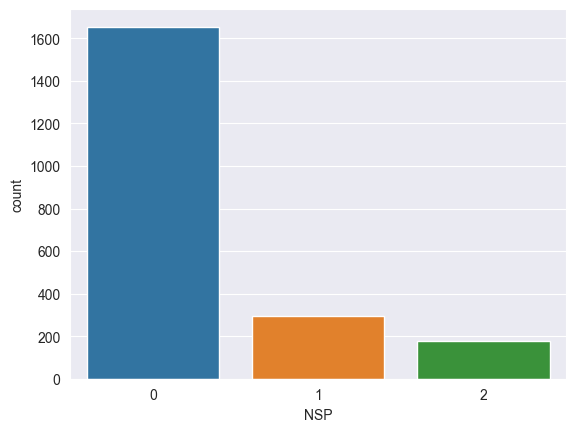

In [6]:
 # Verificando se a variável está balanceada
sns.countplot(x='NSP', data=df);

## Atividade 3: Use as variáveis que achar relevante e separe as variáveis em $X$ e $y$, a seguir crie um modelo de regressão logística.

In [7]:
# Atribuindo variáveis a X e y
X = df.drop('NSP', axis=1)
y = df['NSP']

In [8]:
# Balanceando as classes da variável y
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [9]:
# Adicionando a constante a X
X = sm.add_constant(X)

# Criando o modelo de regressão logística multinomial
model = MNLogit(y, X).fit()

         Current function value: 0.264127
         Iterations: 35


In [10]:
# Visualizando o sumário do modelo
print(model.summary())

                          MNLogit Regression Results                          
Dep. Variable:                    NSP   No. Observations:                 4965
Model:                        MNLogit   Df Residuals:                     4921
Method:                           MLE   Df Model:                           42
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                  0.7596
Time:                        14:11:08   Log-Likelihood:                -1311.4
converged:                      False   LL-Null:                       -5454.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
     NSP=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.7085      1.434    -12.349      0.000     -20.519     -14.898
LB            -0.0973      0.024     -3.996      0.000      -0.145      -0.050
AC         -1077.8739     81.681    -13.196      0.0

## Atividade 4: Faça previsões e avalie o modelo.

In [11]:
# Prevendo as probabilidades de cada classe
model.predict(X)

,0,1,2
0,3.530184e-04,0.864500,1.351465e-01
1,9.999805e-01,0.000019,1.113440e-12
2,9.997948e-01,0.000205,3.251961e-10
3,9.995818e-01,0.000418,8.928563e-13
4,9.999938e-01,0.000006,2.271422e-15
...,...,...,...
4960,3.098495e-02,0.154037,8.149785e-01
4961,7.856096e-09,0.094144,9.058557e-01
4962,6.522868e-10,0.000002,9.999979e-01
4963,1.697754e-02,0.255877,7.271456e-01


In [12]:
# Criando variável que armazena a classe com maior probabilidade
y_pred = model.predict(X).idxmax(axis=1)
y_pred

0       1
1       0
2       0
3       0
4       0
       ..
4960    2
4961    2
4962    2
4963    2
4964    2
Length: 4965, dtype: int64

In [13]:
# Gerando a matriz de confusão
cm = confusion_matrix(y, y_pred)
cm

array([[1494,  131,   30],
       [  75, 1430,  150],
       [  13,  140, 1502]])

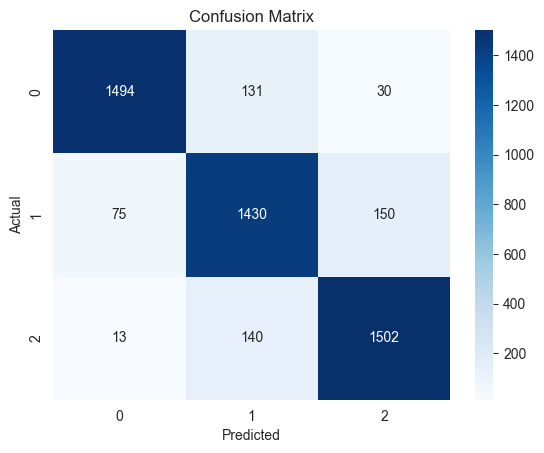

In [14]:
# Gerando mapa de calor da matriz de confusão
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

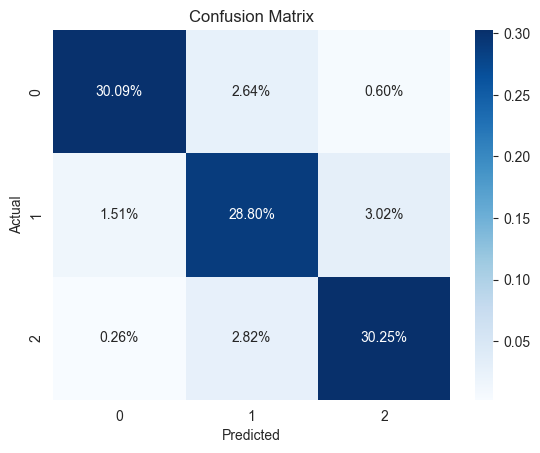

In [15]:
# Gerando mapa de calor da matriz de confusão com valores percentuais
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.2%')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

In [16]:
# Gerando o 'classification report'
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1655
           1       0.84      0.86      0.85      1655
           2       0.89      0.91      0.90      1655

    accuracy                           0.89      4965
   macro avg       0.89      0.89      0.89      4965
weighted avg       0.89      0.89      0.89      4965



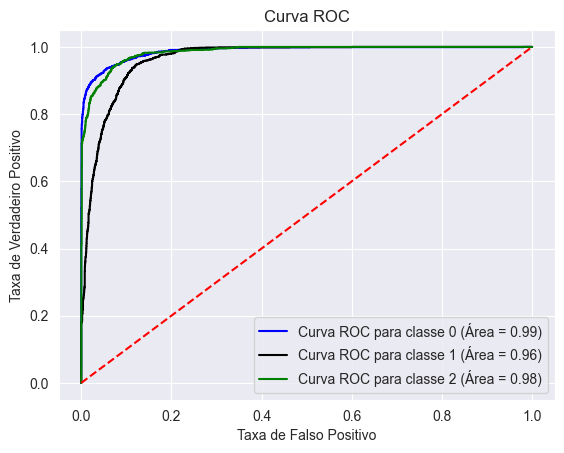

In [17]:
y_cat = label_binarize(y, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_cat.shape[1]
colors = ['blue', 'black', 'green']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_cat[:, i], model.predict(X).iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Curva ROC para classe {i} (Área = {round(roc_auc[i], 2)})')

plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc='lower right')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC');

## Atividade 5: Faça a previsão para um paciente que apresenta as seguintes características:

* `LB` = 121
* `AC` = 0.004176
* `FM` = 0.0
* `UC` = 0.007541
* `DL` = 0.003176
* `DS` = 0.0
* `DP` = 0.0
* `ASTV` = 20
* `mSTV` = 2.3
* `ALTV` = 0
* `mLTV` = 11.5
* `Width` = 129
* `Min` = 54
* `Max` = 171
* `Nmax` = 5
* `Nzeros` = 0
* `Mode` = 140
* `Mean` = 136
* `Median` = 123
* `Variance` = 14
* `Tendency` = 1

In [32]:
# Criando dicionário para armazenar as características do paciente
pacient_data = {
    'const': 1,
    'LB': 121,
    'AC': 0.004176,
    'FM': 0.0,
    'UC': 0.007541,
    'DL': 0.003176,
    'DS': 0.0,
    'DP': 0.0,
    'ASTV': 20,
    'mSTV': 2.3,
    'ALTV': 0,
    'mLTV': 11.5,
    'Width': 129,
    'Min': 54,
    'Max': 171,
    'Nmax': 5,
    'Nzeros': 0,
    'Mode': 140,
    'Mean': 136,
    'Median': 123,
    'Variance': 14,
    'Tendency': 1
}

# Convertendo o dicionário em dataframe
pacient_df = pd.DataFrame(pacient_data, index=[0])
pacient_df

,const,LB,AC,FM,UC,DL,DS,DP,ASTV,mSTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,1,121,0.004176,0.0,0.007541,0.003176,0.0,0.0,20,2.3,...,129,54,171,5,0,140,136,123,14,1


In [33]:
# Prevendo a classe do paciente
pacient_pred = model.predict(pacient_df).idxmax(axis=1)
print(f'De acordo com as características informadas, o modelo prevê que o paciente percente à classe: {pacient_pred[0]}')

De acordo com as características informadas, o modelo prevê que o paciente percente à classe: 0
